In [1]:
import datetime
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
from sklearn.metrics import r2_score


pd.options.plotting.backend = 'plotly'
pd.options.display.max_rows = 100

In [2]:
DATA_DIR = Path.cwd().parent / 'data'
FIGURE_OUTPUT_DIR = Path.cwd().parent / 'results'

## 0. Plot Utils
Define a single plotting function for consistently formatted plots.

In [3]:
PLOT_START_DATE = pd.Timestamp("1990-01-01")
PLOT_END_DATE = pd.Timestamp("2025-01-01")

G7_COUNTRIES = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States', 'European Union']
COUNTRY_COLOR_MAP = {
 'United States': '#0141ff',
 'Germany': '#18a48c',
 'United Kingdom': '#eb003b',
 'Canada': '#97d9e3',
 'France': '#fdb633',
 'Italy': '#f6a4b7',
 'Japan': '#ff6e47',
 'European Union': '#9a20be',
}
EXTRA_COLORS = ['#0e294a', '#646363', '#a59bee', '#f4f1ef', '#000000']
ALL_COLORS = list(COUNTRY_COLOR_MAP.values()) + EXTRA_COLORS

FIGSIZE = (12, 4)
DPI = 100
SAVE_FIG_KWARGS = {
    'bbox_inches': "tight"
}

In [4]:
def plot_country_timeseries(df, title=None, xlim=(PLOT_START_DATE, PLOT_END_DATE), legend=None):
    """Plot time series of G7 countries in a consistent format."""
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

    for country, color in COUNTRY_COLOR_MAP.items():
        alpha = 1 if country=='United Kingdom' else 0.2
        if country in df.columns:
            line = ax.plot(df.index, df[country], label=country, color=color, alpha=alpha)
        
    ax.set_xlim(left=xlim[0], right=xlim[1])

    if title:
        ax.set_title(title)

    if legend:
        plt.legend(loc="best")
        
    return fig, ax

In [5]:
def plot_generic_timeseries(df, title=None, xlim=(PLOT_START_DATE, PLOT_END_DATE), legend=None):
    """Plot time series in a consistent format."""
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

    for idx, colname in enumerate(df.columns):
        line = ax.plot(df.index, df[colname], label=colname, color=ALL_COLORS[idx], alpha=1)
        
    ax.set_xlim(left=xlim[0], right=xlim[1])

    if title:
        ax.set_title(title)

    if legend:
        plt.legend(loc="best")
    
    return fig, ax

## 1. World Bank Data

In [6]:
def load_world_bank_data(fpath, index_year=None) -> pd.DataFrame:
    """Load and pre-process GDP or labour force data sourced from World Bank.

    See: 
    - GDP: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD
    - Labour force participation rate: https://data.worldbank.org/indicator/SL.TLF.CACT.NE.ZS 

    Parameters
    ----------
    fpath: str
        Local filepath to load.
    index_year: int, default None
        If provided, index values 
    
    """
    df = pd.read_csv(fpath, skiprows=[0,1,2,3])
    df = df.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 68'])
    df = df.set_index('Country Name').T
    df.index = df.index.astype(int)
    df.index.name = 'Date'

    if index_year:
        df = (df / df.loc[index_year]) * 100

    return df

### 1.1. GDP Data
Global values sourced from World Bank: https://data.worldbank.org/indicator/NY.GDP.MKTP.CD

In [7]:
gdp_fpath = DATA_DIR / 'global_gdp.csv'
gdp_df = load_world_bank_data(gdp_fpath, index_year=PLOT_START_DATE.year)

gdp_df.tail()

Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Virgin Islands (U.S.),Viet Nam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019,444.008766,400.668726,NaN,666.013126,NaN,759.251567,306.625943,452.852656,824.413845,316.764256,...,NaN,5166.542983,554.553922,385.344070,725.910427,NaN,NaN,308.874079,709.501534,248.550666
2020,334.583074,369.836896,NaN,636.277034,NaN,747.465242,280.955307,402.529275,689.276260,272.892299,...,NaN,5355.834681,538.503856,374.969024,690.883462,NaN,NaN,268.382695,552.102426,244.878726
2021,405.748688,432.611833,NaN,683.844491,NaN,883.908800,323.101683,463.858607,818.869764,345.166898,...,NaN,5662.692060,562.765554,427.326378,671.025419,NaN,NaN,333.299493,672.601362,322.994430
2022,463.478958,471.300284,NaN,709.022266,NaN,932.505676,328.536045,564.557669,1000.097691,446.495602,...,NaN,6340.242003,605.296125,443.529725,662.296184,NaN,NaN,321.520690,887.727619,311.557357
2023,NaN,492.079921,NaN,643.907248,NaN,1132.712301,362.265397,545.472034,994.396637,453.186687,...,NaN,6639.897702,666.934300,461.976256,742.727234,NaN,NaN,299.712158,857.253192,302.126905


In [8]:
gdp_df[G7_COUNTRIES].tail()

Country Name,Canada,France,Germany,Italy,Japan,United Kingdom,United States,European Union
Date,,,,,,,,
2019,292.534237,215.010564,219.520280,170.272911,160.644916,260.838548,360.906847,241.080823
2020,277.764222,208.592910,219.438412,160.635392,158.686076,246.787608,357.578989,236.278398
2021,336.781477,233.170765,241.495370,182.427546,158.027980,287.375972,395.664284,265.982651
2022,362.619003,218.967607,230.430425,174.985816,133.601323,282.558201,431.720381,257.478173
2023,359.029224,238.808128,251.518510,190.891294,132.237013,305.536581,458.834048,281.870237


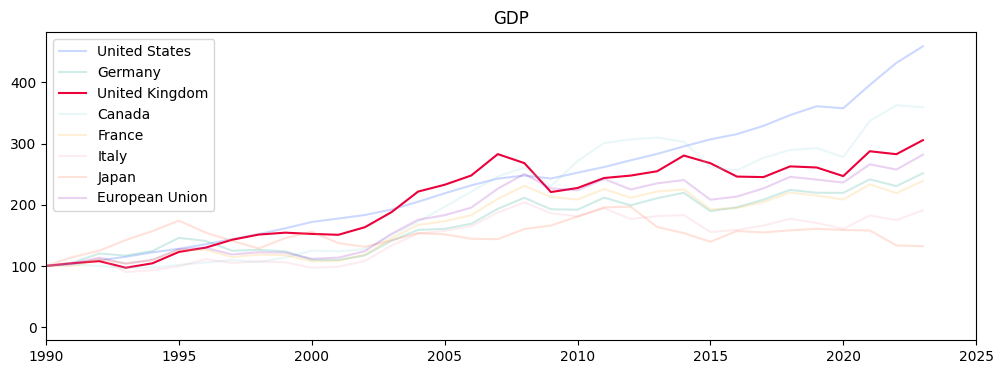

In [9]:
fig, ax = plot_country_timeseries(gdp_df[G7_COUNTRIES],
                                  title="GDP",
                                  legend=True,
                                  xlim=(PLOT_START_DATE.year, PLOT_END_DATE.year))
# fig.savefig(FIGURE_OUTPUT_DIR / "gdp.png", **SAVE_FIG_KWARGS)

### 1.2. Employment data 
Sourced from World Bank for longer time series, https://data.worldbank.org/indicator/SL.TLF.CACT.NE.ZS

In [10]:
labour_fpath = DATA_DIR / 'labour_force_participation_rate.csv'
labour_df = load_world_bank_data(labour_fpath, index_year=None)

labour_df.tail()

Country Name,Aruba,Africa Eastern and Southern,Afghanistan,Africa Western and Central,Angola,Albania,Andorra,Arab World,United Arab Emirates,Argentina,...,Virgin Islands (U.S.),Viet Nam,Vanuatu,World,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2019,NaN,NaN,NaN,60.542087,75.021,60.306,NaN,NaN,80.200,60.289,...,NaN,75.630,58.596,58.261397,NaN,35.696,NaN,58.327,59.539,65.795
2020,NaN,NaN,41.579,NaN,NaN,NaN,NaN,NaN,80.354,56.023,...,NaN,73.283,42.897,NaN,NaN,33.658,NaN,54.701,60.872,NaN
2021,NaN,NaN,49.809,NaN,76.372,NaN,NaN,NaN,76.808,60.358,...,NaN,72.897,NaN,NaN,NaN,34.573,NaN,55.760,60.119,65.398
2022,NaN,NaN,NaN,74.310696,NaN,NaN,NaN,NaN,77.379,61.484,...,NaN,73.625,NaN,NaN,43.801,34.035,NaN,56.942,59.532,65.214
2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.528,NaN,NaN


(<Figure size 1200x400 with 1 Axes>,
 <Axes: title={'center': 'Unemployment (%)'}>)

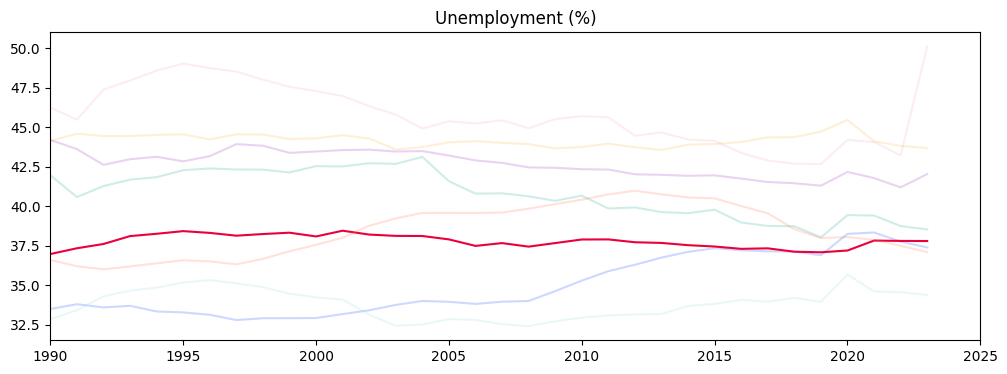

In [11]:
plot_country_timeseries(
    (100 - labour_df[labour_df.index >= PLOT_START_DATE.year][G7_COUNTRIES]),
    title="Unemployment (%)",
    xlim=(PLOT_START_DATE.year, PLOT_END_DATE.year)
)

## 2. LFS Data

In [12]:
def preprocess_field_name(field_name: str) -> str:
    """Some of the field names have naming inconsistencies, so preprocess these for consistency"""
    return (
        field_name
        # Some fields are sentence case, others are upper case. Cast all to lower case
        .lower()  
        # Punctuation is inconsistent so remove
        .replace(':', '')
        .replace('.', '')
        .replace('"', '')
        # Abbreviations are inconsistent
        .replace("economically", "econ")
        .replace("economic", "econ")
        .replace("inactivity", "inact")
        .replace("inactive", "inact")
        .replace("education", "educ")
    )


def load_lfs_data(fpath: str) -> pd.DataFrame:
    """Load and preprocess the LFS monthly data."""
    df = pd.read_csv(
        str(fpath),
        header=[0],
        skiprows=[1,2,3],  # The CDID, PreUnit and Unit headers aren't needed 
        encoding="ISO-8859-1",  # Some of the PreUnit values seem to cause decoding issues with the default utf-8 encoding
        parse_dates=['Title'],
        date_format="%Y %b"  # Parse dates from "2024 JAN" format
    )
    df = df.rename(columns={'Title': 'Date'})
    df = df.set_index("Date")
    df.columns = [preprocess_field_name(k) for k in df.columns]

    return df

In [13]:
lfs_monthly_fpath = DATA_DIR / 'lfs_monthly_variables.csv'
lfs_df = load_lfs_data(lfs_monthly_fpath)
lfs_df

,awe whole economy real terms year on year single month growth (%) seasonally adjusted regular pay,awe whole economy real terms year on year three month growth (%) seasonally adjusted regular pay,awe whole economy real terms level (£) seasonally adjusted regular pay,awe whole economy real terms year on year single month growth (%) seasonally adjusted total pay,awe whole economy real terms year on year three month growth (%) seasonally adjusted total pay,awe whole economy real terms level (£) seasonally adjusted total pay,employment rate canada (oecd) seasonally adjusted,employment rate japan (oecd) seasonally adjusted,employment rate united states (oecd) seasonally adjusted,"standardised ilo unemployment rates, seasonally adjusted, romania - eurostat",...,standardised ilo unemployment rates seasonally adjusted luxembourg - eurostat,standardised ilo unemployment rates seasonally adjusted netherlands - eurostat,standardised ilo unemployment rates seasonally adjusted austria - eurostat,standardised ilo unemployment rates seasonally adjusted portugal - eurostat,standardised ilo unemployment rates seasonally adjusted finland - eurostat,standardised ilo unemployment rates seasonally adjusted sweden - eurostat,standardised ilo unemployment rates seasonally adjusted united kingdom eurostat,standardised ilo unemployment rates seasonally adjusted united states,standardised ilo unemployment rates seasonally adjusted japan- eurostat,standardised ilo unemployment rates seasonally adjusted canada-oecd
Date,,,,,,,,,,,,,,,,,,,,,
1992-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
1992-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.7
1992-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.9
1992-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.4
1992-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,2.0,1.5,482.0,1.4,1.5,513.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-01,1.9,1.8,481.0,1.6,1.4,513.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,1.7,1.9,481.0,1.4,1.5,513.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.1. LFS Unemployment Rates


In [14]:
unemployment_g7_cols = [
    'standardised ilo unemployment rates - total eu',
    'standardised ilo unemployment rates seasonally adjusted germany - eurostat',
    'standardised ilo unemployment rates seasonally adjusted france - eurostat',
    'standardised ilo unemployment rates seasonally adjusted italy - eurostat',
    'standardised ilo unemployment rates seasonally adjusted united kingdom eurostat',
    'standardised ilo unemployment rates seasonally adjusted united states',
    'standardised ilo unemployment rates seasonally adjusted japan- eurostat',
    'standardised ilo unemployment rates seasonally adjusted canada-oecd'
 ]
unemployment_df = lfs_df[unemployment_g7_cols]
unemployment_df.columns = ['European Union', 'Germany', 'France', 'Italy', 'United Kingdom', 'United States', 'Japan', 'Canada']


unemployment_df.dropna().tail()


,European Union,Germany,France,Italy,United Kingdom,United States,Japan,Canada
Date,,,,,,,,
2020-03-01,6.5,3.8,7.5,8.5,3.8,4.4,2.5,7.8
2020-04-01,6.7,4.0,7.8,7.3,3.7,14.7,2.6,13.0
2020-05-01,6.9,4.2,6.9,8.7,3.7,13.3,2.9,13.7
2020-06-01,7.2,4.4,6.6,9.4,3.9,11.1,2.8,12.3
2020-07-01,7.4,4.5,7.1,9.8,4.3,10.2,2.9,10.9


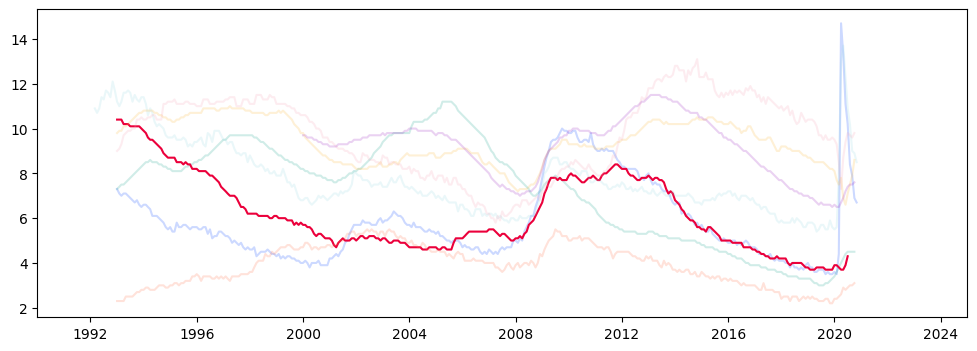

In [15]:
fig, ax = plot_country_timeseries(unemployment_df,
                        # title="Unemployment (%) LFS", 
                        xlim=(PLOT_START_DATE, PLOT_END_DATE))
fig.savefig(FIGURE_OUTPUT_DIR / "unemployment.png", **SAVE_FIG_KWARGS)

### 2.2. Economic Inactivity Demographic Splits

#### 2.2.1. Overall

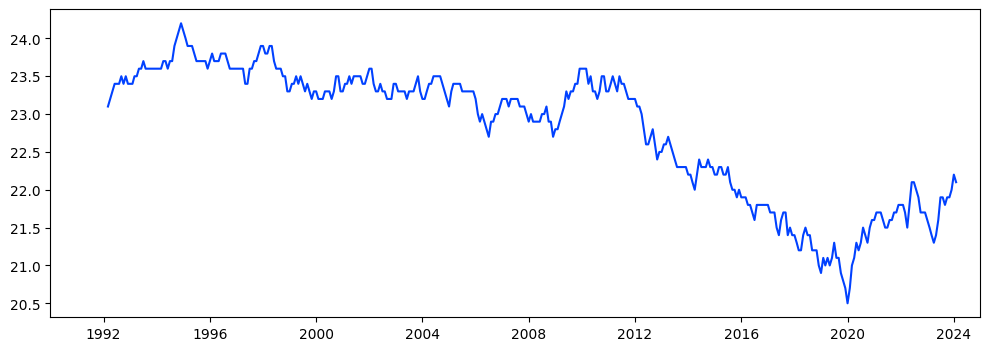

In [16]:
# plot_generic_timeseries(lfs_df[['lfs econ inact rate uk people aged 16 and over % nsa']], title="Economic Inactivity Rate (%) - Total", xlim=(PLOT_START_DATE, PLOT_END_DATE))
fig, ax = plot_generic_timeseries(lfs_df[['lfs econ inact rate uk all aged 16-64 % sa']],
                                  # title="Economic Inactivity Rate (%) - Total",
                                  xlim=(PLOT_START_DATE, PLOT_END_DATE))
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_total.png", **SAVE_FIG_KWARGS)

In [43]:
lfs_df[['lfs econ inact rate uk all aged 16-64 % sa']].plot()

#### 2.2.2. Want to Work

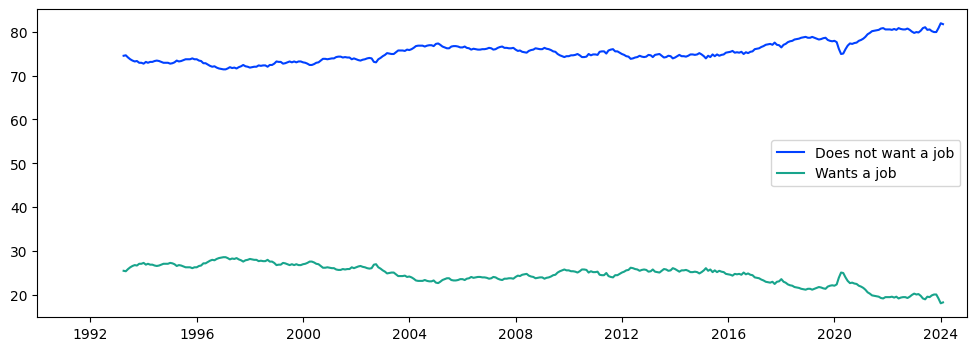

In [17]:
want_cols = {
    'lfs econ inact reasons does not want a job uk 16-64%': 'Does not want a job',
    'lfs econ inact reasons wants a job uk 16-64%': 'Wants a job',
}

fig, ax = plot_generic_timeseries(
    lfs_df[want_cols.keys()].rename(columns=want_cols),
    # title="Economic Inactivity Rate (%) - Desire to Work", 
    xlim=(PLOT_START_DATE, PLOT_END_DATE),
    legend=True
)
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_want_to_work.png", **SAVE_FIG_KWARGS)

In [49]:
reasons_cols = {
    # 'lfs econ inact reasons does not want a job uk 16-64%',
    # 'lfs econ inact reasons wants a job uk 16-64%',
    'lfs econ inact wants a job student uk 16-64%': 'Student',
    'lfs econ inact wants a job temp sick uk 16-64%': 'Temp sick',
    'lfs econ inact wants a job long-term sick uk 16-64%': 'Long-term sick',
    'lfs econ inact wants a job looking after family/home uk 16-64%': 'Looking after family/home',
    'lfs econ inact wants a job discouraged workers uk 16-64%': 'Discouraged Workers',
    'lfs econ inact wants a job other uk 16-64%': 'Other',
    
    'lfs econ inact does not want a job student uk 16-64%': 'Student',
    'lfs econ inact does not want a job temp sick uk 16-64%': 'Temp sick',
    'lfs econ inact does not want a job long-term sick uk 16-64%': 'Long-term sick',
    'lfs econ inact does not want a job retired uk 16-64%': 'Retired',
    'lfs econ inact does not want a job other uk 16-64%': 'Other',
}
reasons_want_cols = [k for k in reasons_cols.keys() if 'wants' in k]
reasons_dont_want_cols = [k for k in reasons_cols.keys() if 'does not want' in k]

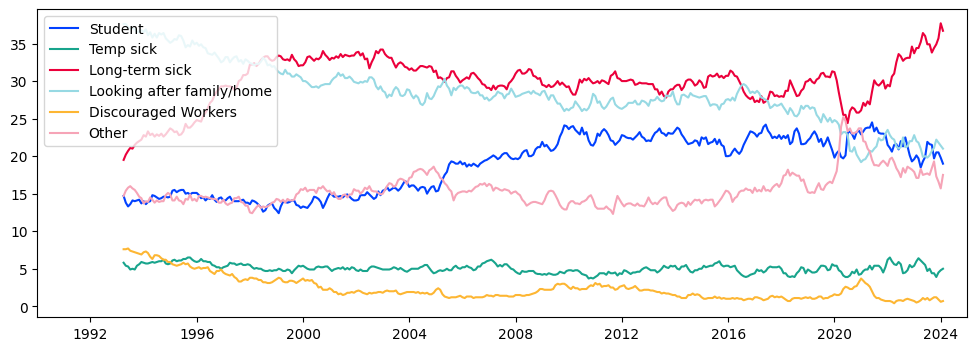

In [52]:
fig, ax = plot_generic_timeseries(
    lfs_df[reasons_want_cols].rename(columns=reasons_cols),
    # title="Economic Inactivity Rate (%) - Want to Work", 
    xlim=(PLOT_START_DATE, PLOT_END_DATE),
    legend=True,
)
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_want_reasons.png", **SAVE_FIG_KWARGS)

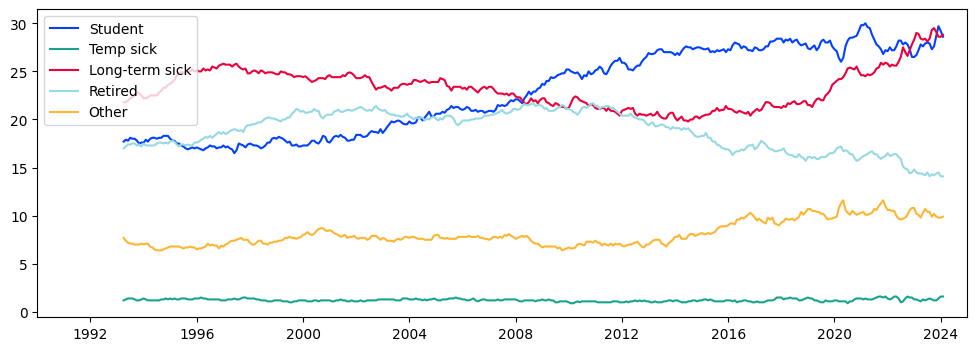

In [53]:
fig, ax = plot_generic_timeseries(
    lfs_df[reasons_dont_want_cols].rename(columns=reasons_cols),
    # title="Economic Inactivity Rate (%) - Do Not Want to Work", 
    legend=True,
    xlim=(PLOT_START_DATE, PLOT_END_DATE)
)        
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_dont_want_reasons.png", **SAVE_FIG_KWARGS)

#### 2.2.3. Sex

In [21]:
sex_cols = {
    'lfs econ inact rate uk female aged 16-64 % sa': 'Female',
    'lfs econ inact rate uk male aged 16-64 % sa': 'Male',
}

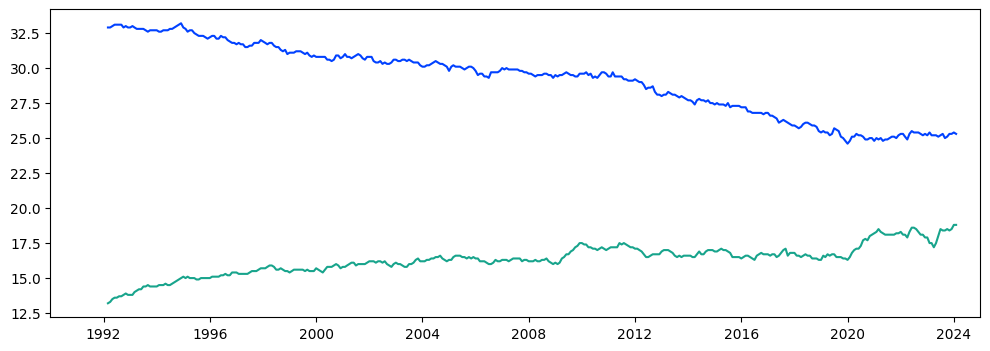

In [22]:
plot_generic_timeseries(
    lfs_df[sex_cols.keys()].rename(columns=sex_cols),
    # title="Economic Inactivity Rate (%) - Sex", 
    xlim=(PLOT_START_DATE, PLOT_END_DATE)
)
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_sex.png", **SAVE_FIG_KWARGS)

#### 2.2.4. Region

In [23]:
region_cols = [ 
 'lfs econ inact rate north east aged 16-64 all % sa',
 'lfs econ inact rate north west aged 16-64 all % sa',
 'lfs econ inact rate yorks & the humber aged 16-64 all % sa',
 'lfs econ inact rate east midlands aged 16-64 all % sa',
 'lfs econ inact rate west midlands aged 16-64 all % sa',
 'lfs econ inact rate east aged 16-64 all % sa',
 'lfs econ inact rate london aged 16-64 all % sa',
 'lfs econ inact rate south east (gor) aged 16-64 all % sa',
 'lfs econ inact rate south west aged 16-64 all % sa',
 'lfs econ inact rate england aged 16-64 all % sa',
 'lfs econ inact rate wales aged 16-64 all % sa',
 'lfs econ inact rate scotland aged 16-64 all % sa'
]

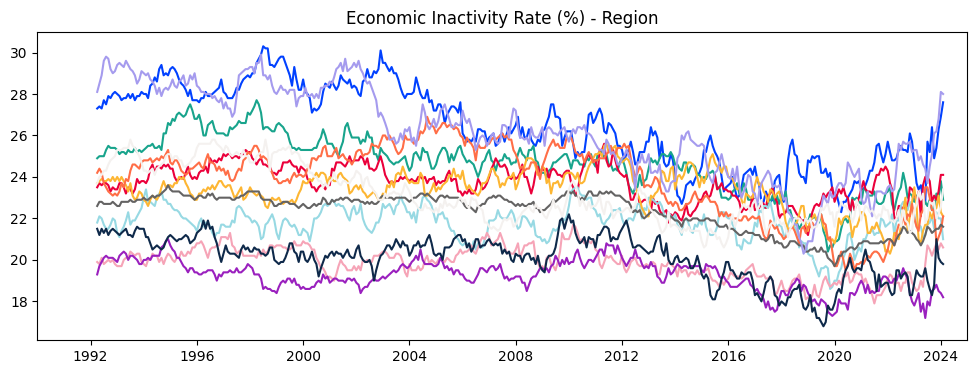

In [24]:
plot_generic_timeseries(
    lfs_df[region_cols],
    title="Economic Inactivity Rate (%) - Region", 
    # legend=True,
    xlim=(PLOT_START_DATE, PLOT_END_DATE)
)
fig.savefig(FIGURE_OUTPUT_DIR / "inactivity_region.png", **SAVE_FIG_KWARGS)

## 4. Productivity Data
Sourced from OECD "Productivity Levels": https://data-explorer.oecd.org/vis?tm=productivity&pg=0&snb=371&df[ds]=dsDisseminateFinalDMZ&df[id]=DSD_PDB%40DF_PDB_LV&df[ag]=OECD.SDD.TPS&df[vs]=1.0&dq=.A.GDPHRS......&lom=LASTNPERIODS&lo=5&to[TIME_PERIOD]=false&ly[cl]=TIME_PERIOD&ly[rw]=REF_AREA%2CCOMBINED_UNIT_MEASURE&vw=ov

In [26]:
productivity_fpath = DATA_DIR / 'oecd_productivity.csv'

In [27]:
def load_oecd_data(fpath):
    df = pd.read_csv(fpath)
    df['Date'] = df['TIME_PERIOD'].apply(lambda year: pd.Timestamp(year=year, month=1, day=1))

    return df

In [28]:
def preprocess_oecd_data(df, measure, unit):
    oecd_cols = ['Date', 'Reference area', 'OBS_VALUE']
    filtered_df = df[(df['Measure'] == measure) & (productivity_df['Unit of measure'] == unit)]
    pivoted_df = filtered_df[oecd_cols].pivot_table(columns='Reference area', index='Date', values='OBS_VALUE')
    pivoted_df = pivoted_df.rename(columns={'European Union (27 countries from 01/02/2020)': 'European Union'})

    return pivoted_df

In [29]:
productivity_df = load_oecd_data(productivity_fpath)

prod_gdp_per_person_df = preprocess_oecd_data(productivity_df, 'GDP per person employed', 'US dollars per person, PPP converted')
prod_gdp_per_hour = preprocess_oecd_data(productivity_df, 'GDP per hour worked', 'US dollars per hour, PPP converted')

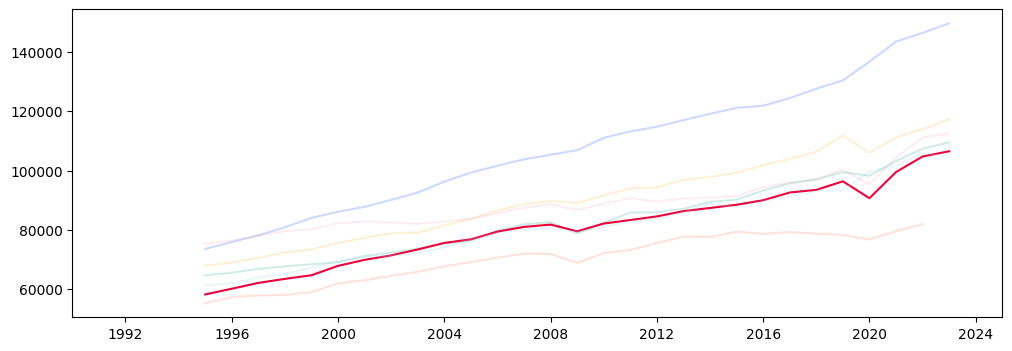

In [30]:
fig, ax = plot_country_timeseries(prod_gdp_per_person_df.filter(G7_COUNTRIES),
                                #    title="GDP per Person Employed ($)", 
                                   xlim=(PLOT_START_DATE, PLOT_END_DATE))
fig.savefig(FIGURE_OUTPUT_DIR / "gdp_per_person.png", **SAVE_FIG_KWARGS)

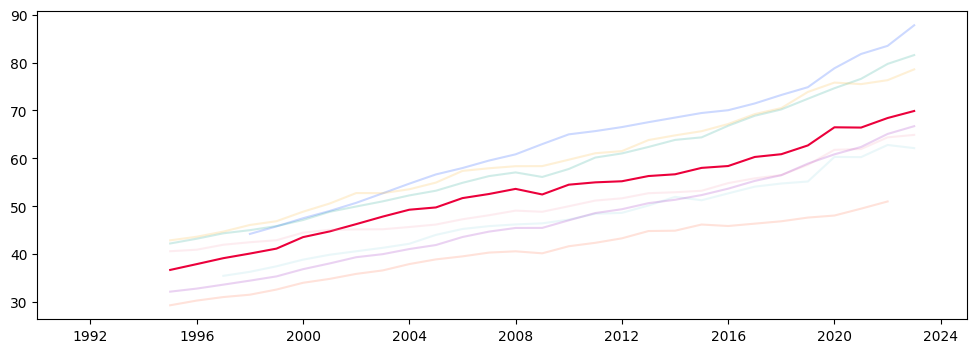

In [31]:
fig, ax = plot_country_timeseries(prod_gdp_per_hour.filter(G7_COUNTRIES),
                                #    title="GDP per Hour ($)", 
                                   xlim=(PLOT_START_DATE, PLOT_END_DATE))
fig.savefig(FIGURE_OUTPUT_DIR / "gdp_per_hour.png", **SAVE_FIG_KWARGS)

## 5. Correlations

In [32]:
gdp_uk = gdp_df[['United Kingdom']]
gdp_uk.index = [datetime.date(year, 1, 1) for year in gdp_uk.index]
gdp_uk.columns = ['GDP']

gdp_uk.tail()


,GDP
2019-01-01,260.838548
2020-01-01,246.787608
2021-01-01,287.375972
2022-01-01,282.558201
2023-01-01,305.536581


In [33]:
unemployment_uk = unemployment_df[['United Kingdom']].resample('YS').mean()
unemployment_uk.columns = ['Unemployment']
unemployment_uk.index = [k.date() for k in unemployment_uk.index]

unemployment_uk.tail()


,Unemployment
2020-01-01,3.885714
2021-01-01,NaN
2022-01-01,NaN
2023-01-01,NaN
2024-01-01,NaN


In [34]:
prod_uk = prod_gdp_per_person_df[['United Kingdom']]
prod_uk.columns = ['Productivity']
prod_uk.index = [k.date() for k in prod_uk.index]

prod_uk.tail()

,Productivity
2019-01-01,96357.316017
2020-01-01,90672.179992
2021-01-01,99496.475888
2022-01-01,104742.824284
2023-01-01,106500.893644


In [35]:
macro_df = pd.concat([gdp_uk, unemployment_uk, prod_uk], axis=1)
macro_df.tail()

,GDP,Unemployment,Productivity
2020-01-01,246.787608,3.885714,90672.179992
2021-01-01,287.375972,NaN,99496.475888
2022-01-01,282.558201,NaN,104742.824284
2023-01-01,305.536581,NaN,106500.893644
2024-01-01,NaN,NaN,NaN


In [36]:
macro_df.corr()

,GDP,Unemployment,Productivity
GDP,1.000000,-0.512237,0.911935
Unemployment,-0.512237,1.000000,-0.417426
Productivity,0.911935,-0.417426,1.000000


In [38]:
r2_score(macro_df.dropna(how='any', subset=['GDP', 'Unemployment'])['GDP'],
         macro_df.dropna(how='any', subset=['GDP', 'Unemployment'])['Unemployment'])

-12.45238113206431

In [39]:
r2_score(macro_df.dropna(how='any', subset=['GDP', 'Productivity'])['GDP'],
         macro_df.dropna(how='any', subset=['GDP', 'Productivity'])['Productivity'])

-2349674.1931072227